# Training strategies

In [1]:
import copy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import train_test_split

data: pd.DataFrame = pd.read_csv('datasets/qsar_oral_toxicity_v2.csv')
original_data = copy.deepcopy(data)
target = 'IS_TOXIC'
positive = 'positive'
negative = 'negative'
print(data['IS_TOXIC'].value_counts())
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}
y: np.ndarray = data.pop('IS_TOXIC').values
X: np.ndarray = data.values
labels: np.ndarray = pd.unique(y)

negative    8251
positive     741
Name: IS_TOXIC, dtype: int64


{'Original': [741, 8251], 'Train': [519, 5775], 'Test': [222, 2476]}


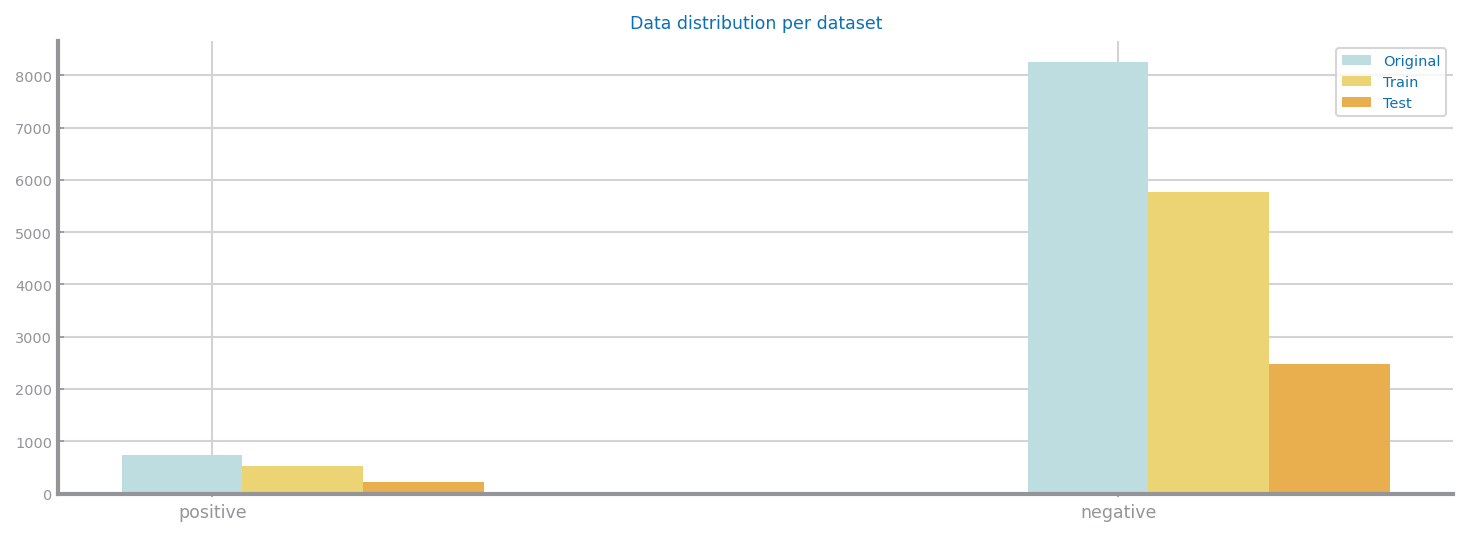

In [12]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]
plt.figure(figsize=(12,4))
print(values)
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

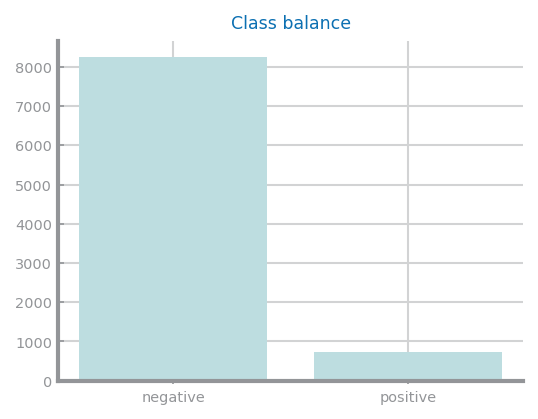

IS_TOXIC = Positive Minority class: 741
IS_TOXIC = Negative Majority class: 8251
Proportion: 0.09 : 1


In [13]:
target_count = original_data['IS_TOXIC'].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('IS_TOXIC = Positive Minority class:', target_count[ind_min_class])
print('IS_TOXIC = Negative Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 2), ': 1')

Given the prior proportion, we consider that a Data Balancing Technique is needed.

## ROC chart

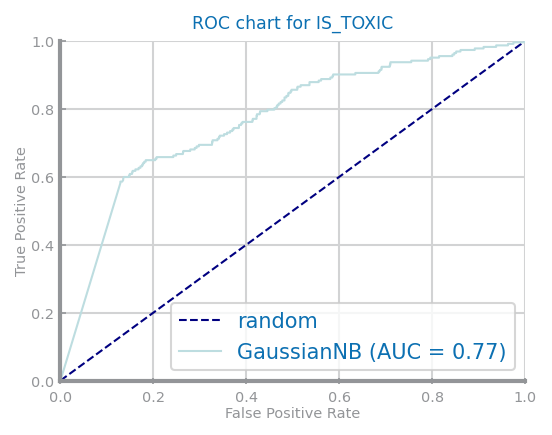

In [8]:
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB

def plot_roc_chart(models: dict, tstX: np.ndarray, tstY: np.ndarray, ax: plt.Axes = None, target: str = 'class'):
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s' % target)

    ax.plot([0, 1], [0, 1], color='navy', label='random', linewidth=1, linestyle='--',  marker='')
    for clf in models.keys():
        metrics.plot_roc_curve(models[clf], tstX, tstY, ax=ax, marker='', linewidth=1)
    ax.legend(loc="lower right")


data = pd.read_csv('datasets/qsar_oral_toxicity_v2.csv')
y = data.pop('IS_TOXIC').values
X = data.values
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
model = GaussianNB().fit(trnX, trnY)

plt.figure()
plot_roc_chart({'GaussianNB': model}, tstX, tstY, target='IS_TOXIC')
plt.show()

# Scaling

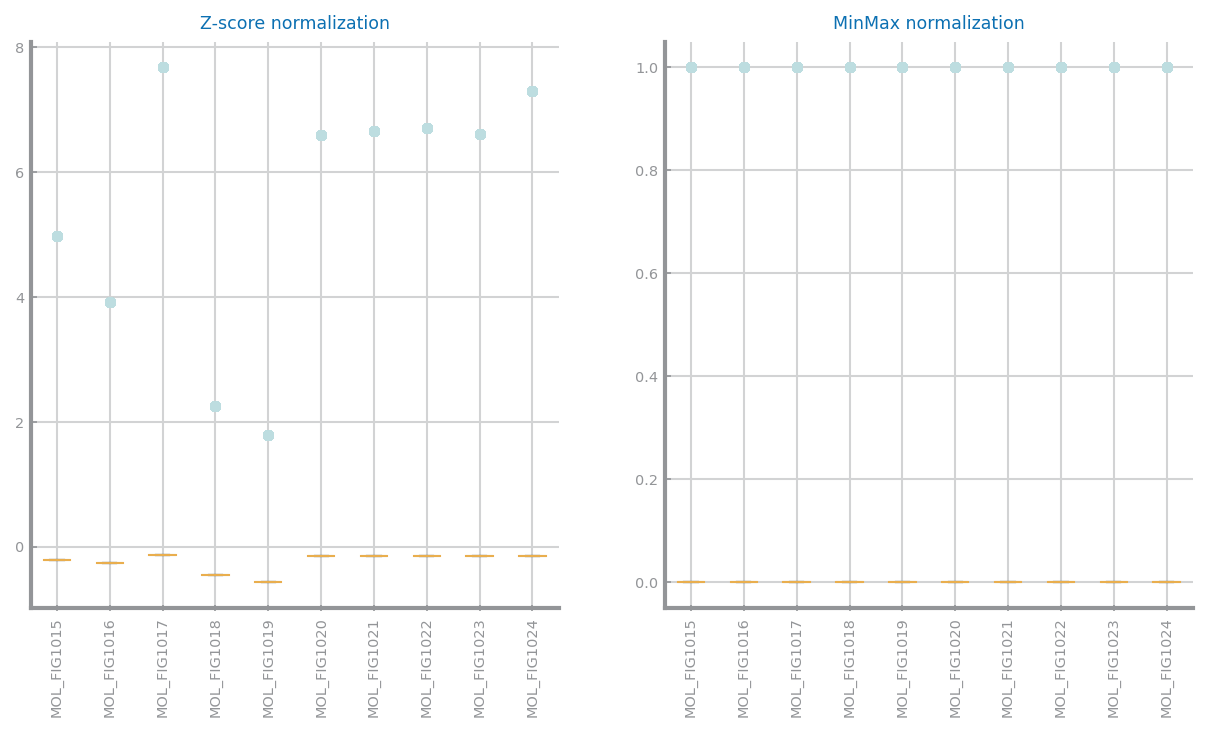

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for i in range(1,1015):
    data = data.drop('MOL_FIG'+ str(i), 1)
    
transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(data)
df_nr = pd.DataFrame(transf.transform(data), columns= data.columns)
norm_data_zscore = df_nr
norm_data_zscore.describe(include='all')

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_minmax = df_nr
norm_data_minmax.describe(include='all')

fig, axs = plt.subplots(1, 2, figsize=(10,5),squeeze=False )
axs[0, 0].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('MinMax normalization')
# axs[0, 2].xticks(rotation=90)
norm_data_minmax.boxplot(ax=axs[0, 1])
# fig.tight_layout()
for i in range(2):
    plt.setp(axs[0, i].xaxis.get_majorticklabels(), rotation=90)
    
plt.show()

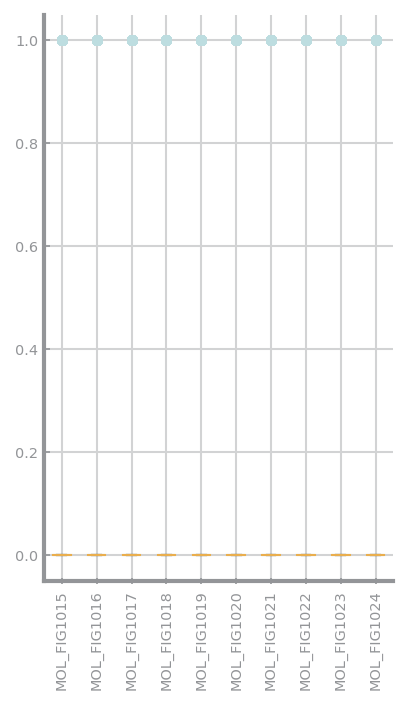

In [10]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
df_nr.boxplot(figsize=(3,5))
plt.xticks(rotation=90)
plt.show()

As shown above, after MinMax normalization the new attribute takes on values in the range [0, 1]. Because all attributes were already between 0 and 1, each value was not restrictly scaled by the sample range. Conversely, after the Z-score normalization, the new attributes have mean equal to 0 and standard deviation 1.

# Naive Bayes

Confusion Matrix Test
TruePositives:  2199
FalsePositives:  96
TrueNegatives:  126
FalseNegatives:  277


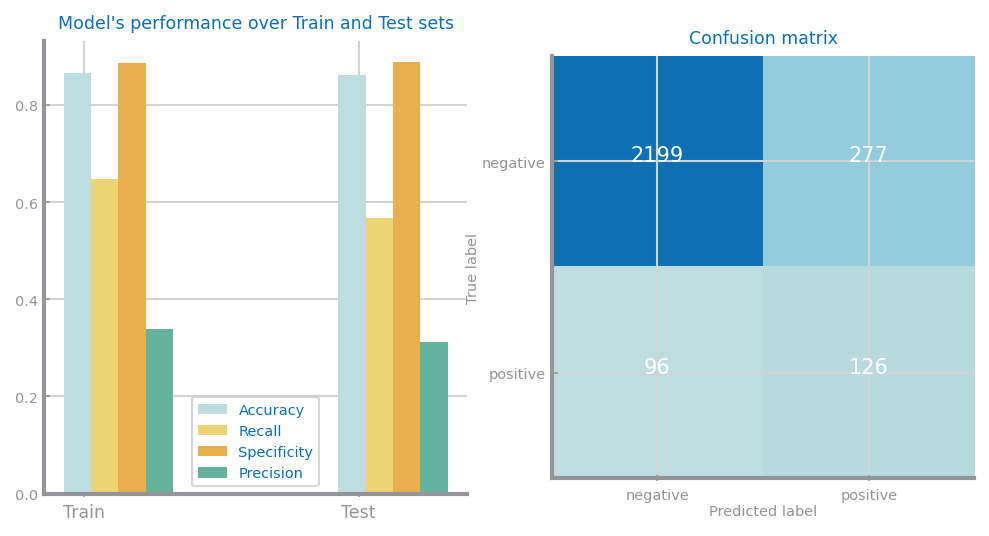

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.naive_bayes import *
import ds_functions as ds

data: pd.DataFrame = pd.read_csv('datasets/qsar_oral_toxicity_v2.csv')
y: np.ndarray = data.pop('IS_TOXIC').values
X: np.ndarray = data.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

clf = MultinomialNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

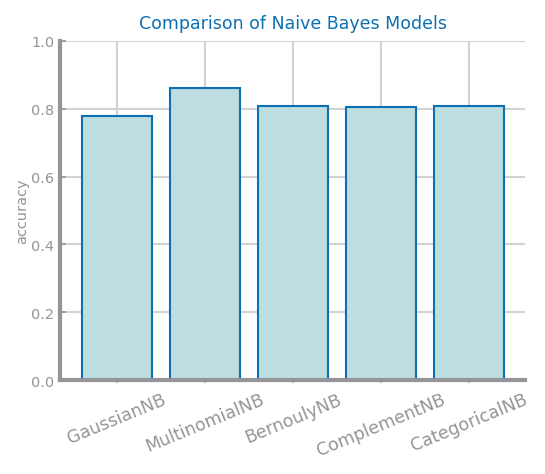

In [12]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulyNB': BernoulliNB(),
              'ComplementNB': ComplementNB(),
              'CategoricalNB': CategoricalNB()
             }

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.xticks(rotation=22.5)
plt.show()

* GaussianNB: implements the Gaussian Naive Bayes algorithm for classification, wherein the likelihood of the features is assumed to be Gaussian
* MultinomialNB: implements the naive Bayes algorithm for multinomially distributed data, suitable for classification with discrete features
* BernoulyNB: implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions, ie, there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable
* ComplementNB: implements the complement naive Bayes algorithm, an adaptation of the standard multinomial naive Bayes using statistics from the complement of each class to compute the model’s weights
* CategoricalNB: implements the categorical naive Bayes algorithm for categorically distributed data, in which it assumes that each feature, which is described by the index, has its own categorical distribution

Bearing in mind that all attributes are either 0 or 1, hence discrete features, Multinomial model has a higher accuracy.

# KNN

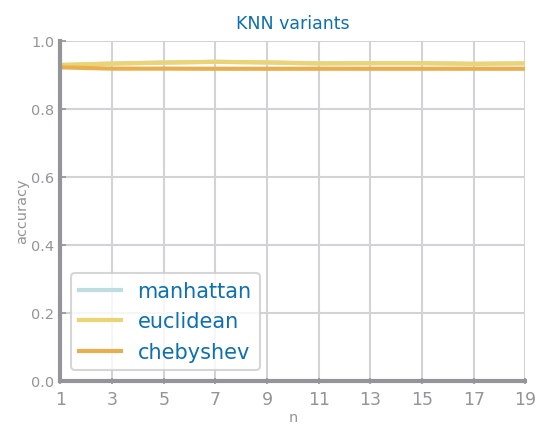

Best results with 7 neighbors and manhattan


In [13]:
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier

labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

Confusion Matrix Test
TruePositives:  2441
FalsePositives:  132
TrueNegatives:  90
FalseNegatives:  35


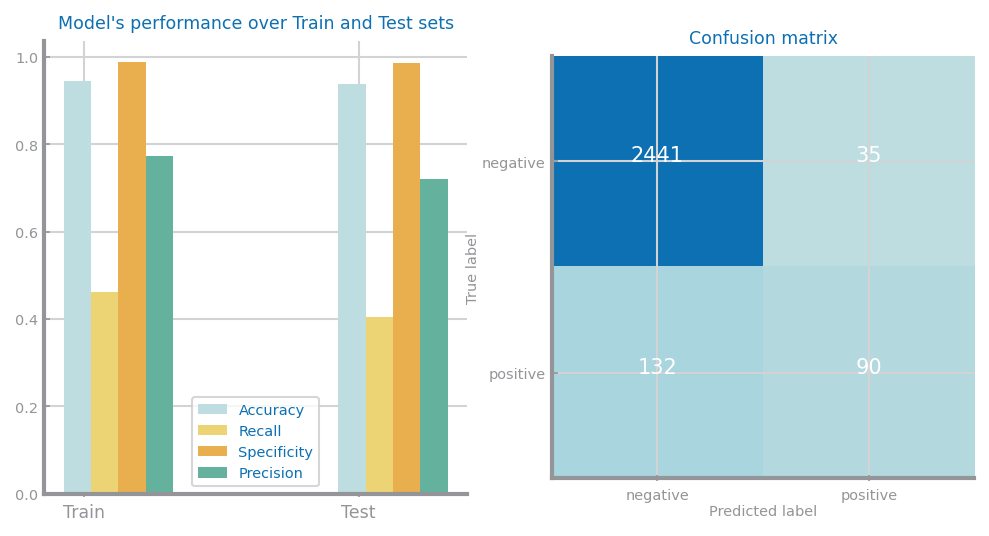

In [14]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)